In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad, create_organo
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference, set_init_point)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
nf, r_in, r_out = (20, 3, 5)
organo = create_organo(nf, r_in, r_out, seed=1553, rot=np.pi/12)

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)

Reseting datasets values with new specs


      fun: 0.7380122652055985
 hess_inv: <80x80 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00151138,  0.00219505,  0.00287251, -0.00181441, -0.00167023,
        0.00303734, -0.00051318,  0.00073992,  0.00282969, -0.0312543 ,
       -0.00236352,  0.02836807, -0.03127694,  0.06950668,  0.02699958,
       -0.06833762, -0.00037356,  0.00084427,  0.00214237, -0.00306806,
       -0.00031719,  0.00044728, -0.00161588,  0.0010077 , -0.00061776,
        0.00503538,  0.00068184,  0.00276938, -0.00226904, -0.00081154,
       -0.00425802, -0.00481719, -0.00061375,  0.0187912 ,  0.0001246 ,
       -0.00889884,  0.00197112, -0.00332038, -0.00118531,  0.00078626,
        0.00029629, -0.00010033,  0.00092173,  0.00067123,  0.00163033,
       -0.00086004, -0.0003667 , -0.00053313,  0.00220731, -0.00029461,
       -0.00194857, -0.00075915,  0.00017533,  0.00418156,  0.00229748,
        0.00366901,  0.0018995 ,  0.00058467,  0.00028806, -0.00402392,
       -0.00255261,  0.00184475, -0.0

In [3]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

Force inference with tensions and pressions solved with NNLS

Solving time: 0.9904030000000006
Distance from th organo to exp organo : 9.656664829555954
Distance from th tensions to exp tensions : 0.3901930162928166


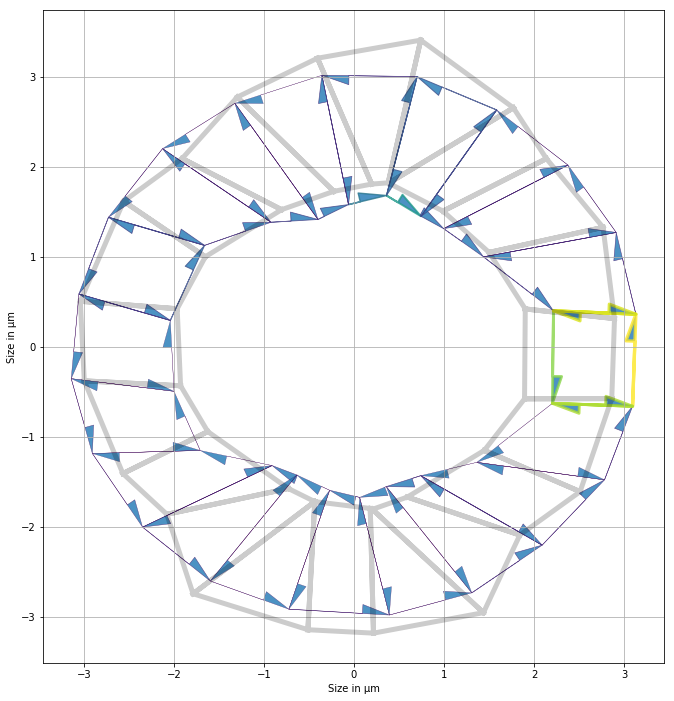

In [4]:
nb_cells = organo.Nf
initial_guess = infer_forces(organo, 'NNLS', sup_param='areas')
start = time.clock()
areas_organo = organo.copy()
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo,
                                                            initial_guess['tensions'])
#print('Energy before optimization: ', model.compute_energy(areas_organo, False))
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
#print('Energy after optimization: ', model.compute_energy(areas_organo, False))
print_tensions(areas_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, areas_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] - initial_guess['tensions']))))

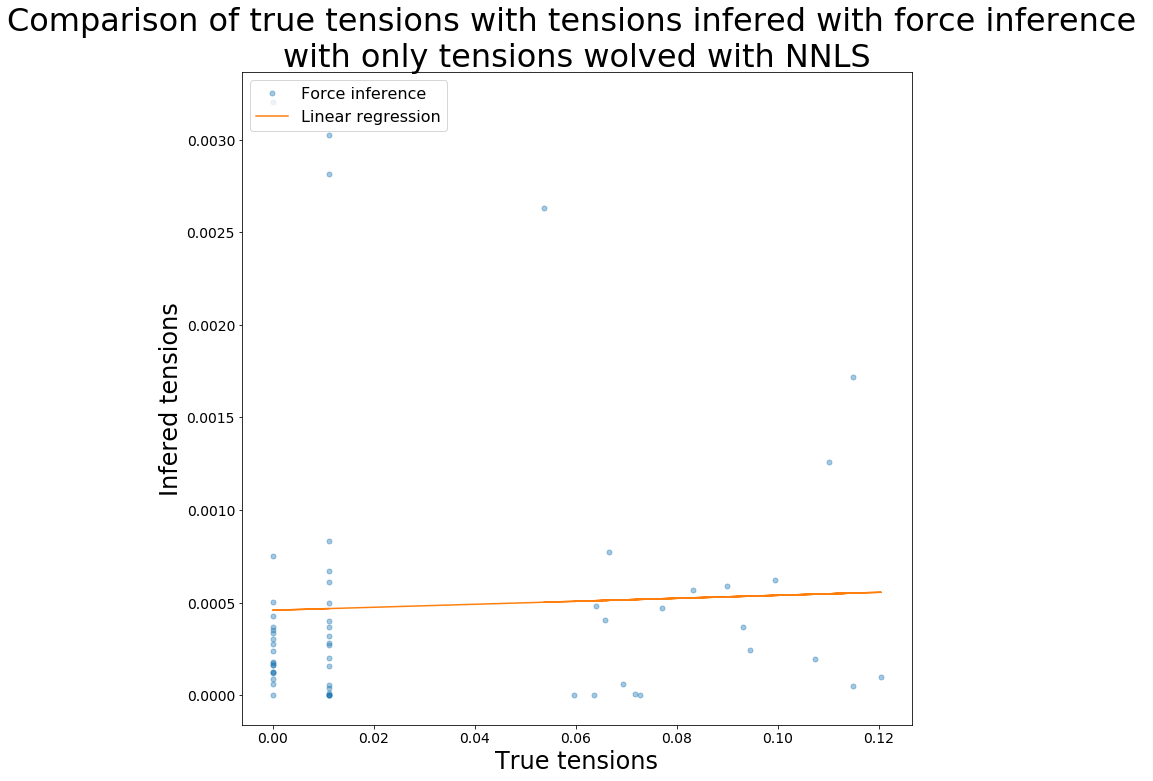

R value : 0.0439149853249243 
Standard error : 0.000625704229640434


In [5]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  initial_guess['tensions'],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

Scale factor optimization

iter   time      nfev    incumbent   f(incumbent)
   1   18.04      10      1.00000     9.28658
   2   27.32      20      1.40000     9.17716
   3   37.64      31      1.45000     9.16203
   4   47.07      41      1.45400     9.16084
Brut force search summary
              solving time: 47.071964263916016
              nb iter: 4
              nfev: 41
              x_ub: 1.453999999999999
              ub: 9.160844769955627
Optimization terminated successfully.
         Current function value: 9.135124
         Iterations: 14
         Function evaluations: 28
Solving time: 75.483519


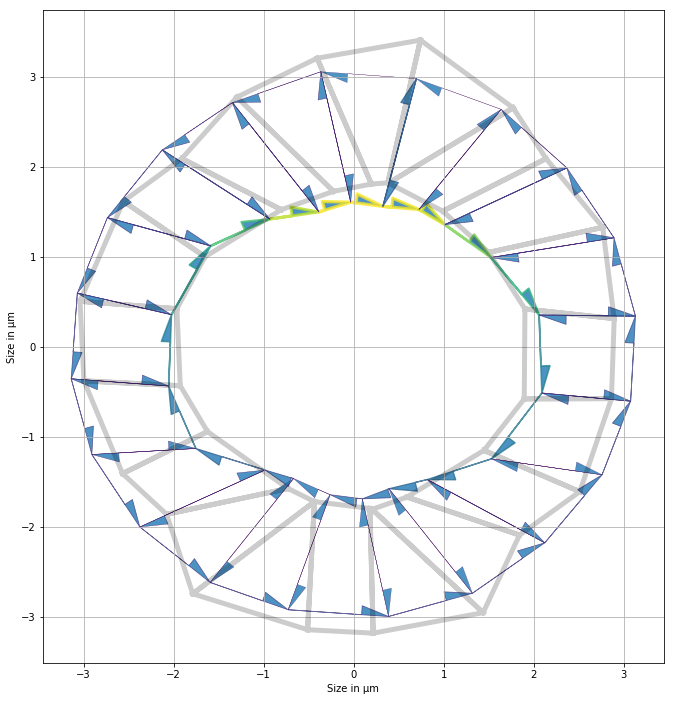

In [6]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='')
start = time.clock()
rescaled_areas_organo = organo.copy()
opt_scale = adjust_scale(organo,
                         initial_guess['tensions'],
                         verbose=2,
                         **nm_opt)
rescaled_areas_organo.edge_df.line_tension = prepare_tensions(rescaled_areas_organo,
                                                                     opt_scale.x*initial_guess['tensions'])
Solver.find_energy_min(rescaled_areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(rescaled_areas_organo, organo)

In [7]:
dist_init_point = np.sum(np.linalg.norm(_distance(areas_organo, rescaled_areas_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(organo, rescaled_areas_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                             areas_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                         rescaled_areas_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th organo to exp organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at optima : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 2.1754484081749745
Distance from th organo to exp organo at optima: 9.135123743351592
Distance from th tensions to exp tensions at initial point : 0.3901930162928166
Distance from th tensions to exp tensions at optima : 0.3858313005808567


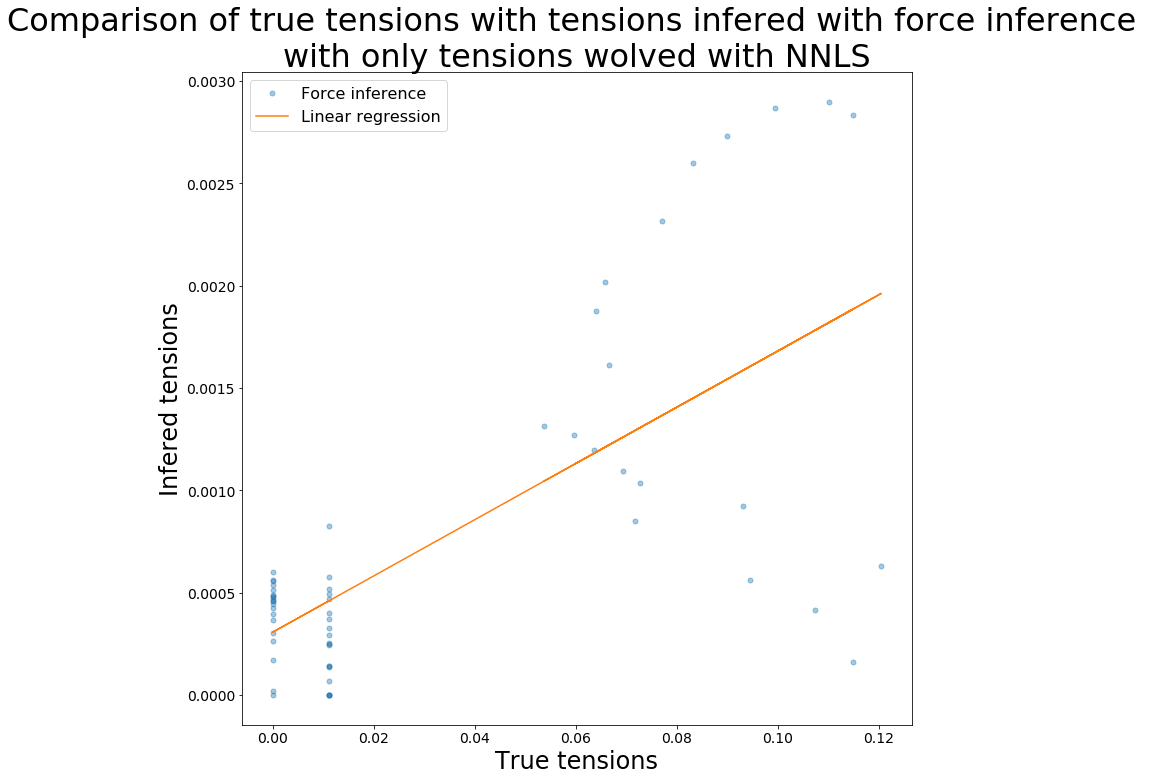

R value : 0.6902175527123 
Standard error : 0.0004912698818963306


In [8]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  rescaled_areas_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

Distance minimization

`ftol` termination condition is satisfied.
Function evaluations 741, initial cost 6.1973e-01, final cost 4.5628e-01, first-order optimality 3.02e+04.
Solving time: 514.48839
Distance from th organo to exp organo : 8.850488807653877
Distance from th tensions to exp tensions : 0.38554801604041933


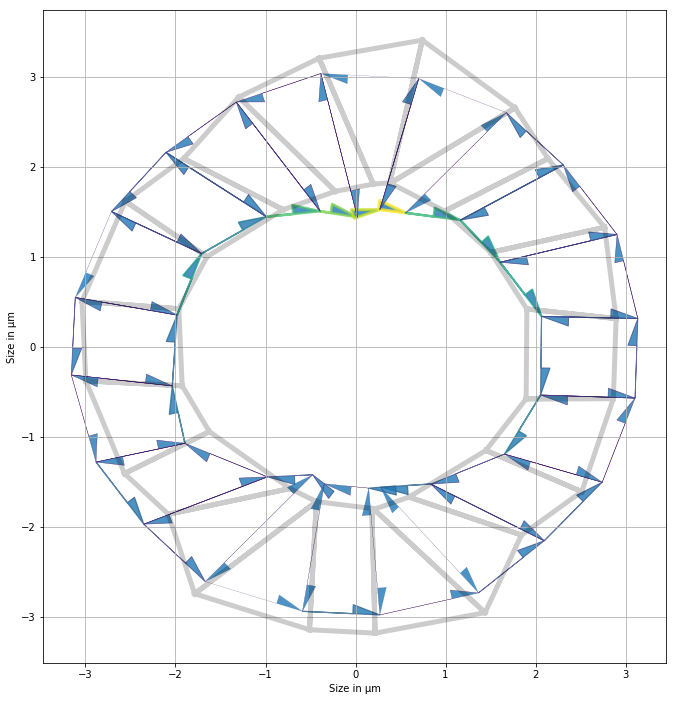

In [9]:
iprint_file = "../../assets/dist_at_each_f_ev/30_01_syn_areas.txt"
res_sym_tensions = adjust_tensions(organo, opt_scale.x*initial_guess['tensions'], 
                                   {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                   energy_opt, iprint_file=iprint_file, **lm_opt)
opt_areas_organo = organo.copy()
opt_areas_organo.edge_df.line_tension = prepare_tensions(opt_areas_organo, res_sym_tensions.x)
Solver.find_energy_min(opt_areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_areas_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, opt_areas_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                opt_areas_organo.edge_df.line_tension[:3*nb_cells]))))

In [13]:
dist_init_point = np.sum(np.linalg.norm(_distance(rescaled_areas_organo, opt_areas_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(rescaled_areas_organo, opt_areas_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                             rescaled_areas_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                         opt_areas_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th organo to exp organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 3.1528818099384663
Distance from th organo to exp organo at optima: 3.1528818099384663
Distance from th tensions to exp tensions at initial point : 0.3858313005808567
Distance from th tensions to exp tensions at initial point : 0.38554801604041933


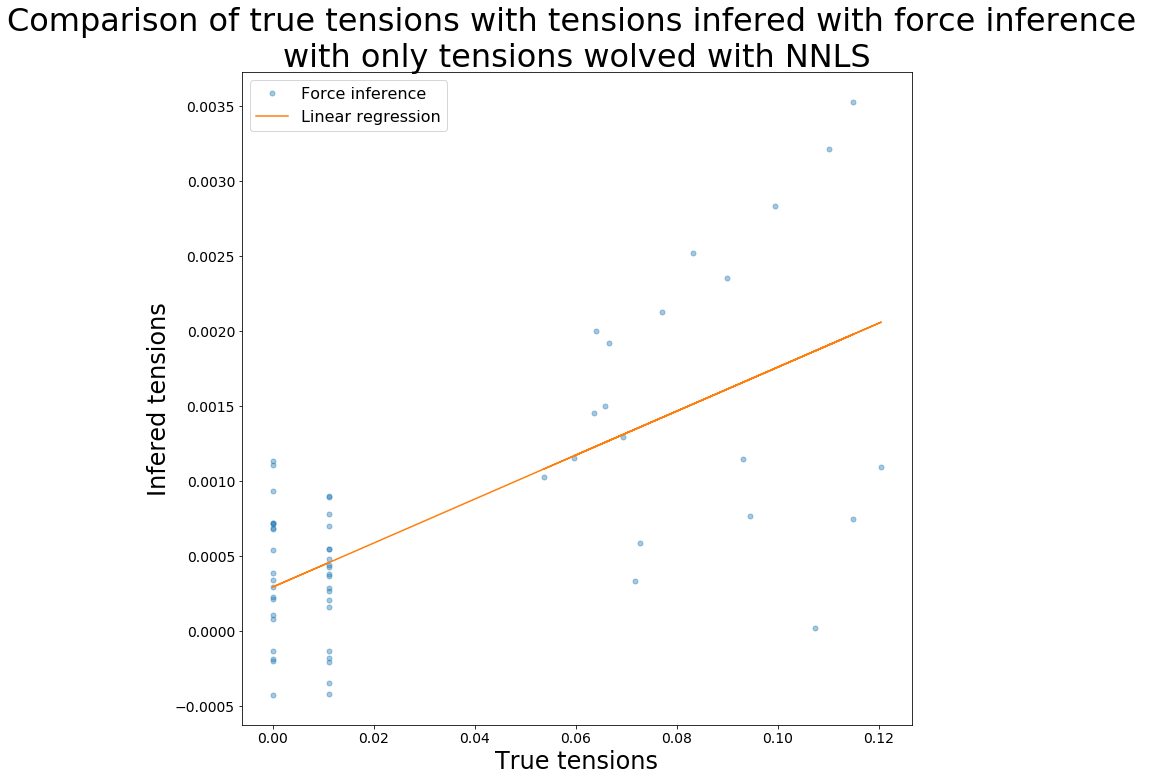

R value : 0.6714066803565171 
Standard error : 0.0005525637952501605


In [11]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  opt_areas_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

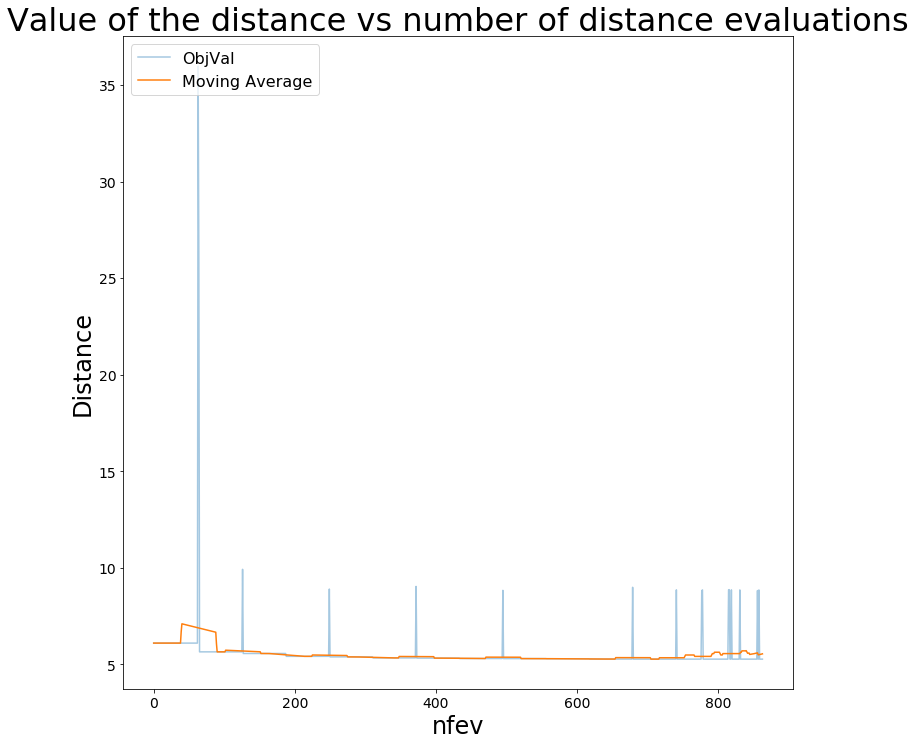

In [12]:
iter_data = pd.read_csv(iprint_file, header=None)
rendering_convergence_results(np.arange(len(iter_data[0])),
                              iter_data[0],
                              'Value of the distance vs number of distance evaluations',
                              'nfev', 'Distance', ('ObjVal', 'Moving Average'),
                              data_dot='-', rol_win=50)